In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

from siuba import *
import pandas as pd
import geopandas as gpd
import datetime as dt

from rt_analysis import rt_parser
from rt_analysis import rt_filter_map_plot

import shared_utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Checking if intermediate data is available

   * First, decide on a date of interest. Let's use October 8, 2022
   * The shared_utils.rt_utils.get_operators function takes the analysis date as a datetime.date object, which we'll construct below
   * It also takes a list of operators (currently itp_ids) of interest
   * Let's start with Big Blue Bus (300)

In [2]:
shared_utils.rt_utils.get_operators?

Signature: shared_utils.rt_utils.get_operators(analysis_date, operator_list)
Docstring:
Function for checking the existence of rt_trips and stop_delay_views in GCS for operators on a given day.

analysis_date: datetime.date
operator_list: list of itp_id's
File:      ~/data-analyses/_shared_utils/shared_utils/rt_utils.py
Type:      function


In [3]:
analysis_date = dt.date(2022, 10, 8)

In [4]:
shared_utils.rt_utils.get_operators(analysis_date, [300])

already ran: 300


{300: 'already_ran'}

In [5]:
shared_utils.rt_utils.get_operators(dt.date(2022, 12, 31), [300])

not yet run: 300


{300: 'not_yet_run'}

Function returns a dictionary of the status of each itp_id passed (in addition to printing it out).

# Generating intermediate data

We can process raw data for a given date and feed directly using `rt_parser.OperatorDayAnalysis`. Let's also give the function a tqdm progress bar using the `pbar` attribute.

_if you're running this notebook yourself, this date+operator might be already ran! feel free to try another if you're curious about the generation process, or skip to the next section._

In [6]:
from tqdm.notebook import tqdm

In [7]:
pbar = tqdm()

0it [00:00, ?it/s]

In [8]:
rt_parser.OperatorDayAnalysis?

Init signature: rt_parser.OperatorDayAnalysis(itp_id, analysis_date, pbar=None)
Docstring:     
New top-level class for rt delay/speed analysis of a single operator on a single day
    
File:           ~/data-analyses/rt_delay/rt_analysis/rt_parser.py
Type:           type
Subclasses:     


In [9]:
rt_day = rt_parser.OperatorDayAnalysis(300, analysis_date, pbar) # don't worry about the CRS not set UserWarning

found parquet
found parquet
found parquet
found parquet
found parquet


/opt/conda/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83 / California Albers (the single non-null crs provided).
/opt/conda/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83 / California Albers (the single non-null crs provided).
/opt/conda/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83 / California Albers (the single non-null crs provided).
/opt/conda/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83 / California Albers (the single non-null crs provided).
/opt/conda/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's

Then, we can save the intermediate data created with the `OperatorDayAnalysis.export_views_gcs()` method

In [43]:
rt_day.export_views_gcs()

# Generate a speedmap with RtFilterMapper

   * First, we'll construct an `RtFilterMapper` object from intermediate data using `rt_filter_map_plot.from_gcs()`
   * Be sure to check first with `shared_utils.rt_utils.get_operators` that data is available. Otherwise, you'll get an error

In [11]:
rt_filter_map_plot.from_gcs?

Signature: rt_filter_map_plot.from_gcs(itp_id, analysis_date, pbar=None)
Docstring:
Generates RtFilterMapper from cached artifacts in GCS. Generate using rt_analysis.OperatorDayAnalysis.export_views_gcs()
    
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      function


In [12]:
import importlib
importlib.reload(rt_filter_map_plot)

<module 'rt_analysis.rt_filter_map_plot' from '/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py'>

In [13]:
rt_day = rt_filter_map_plot.from_gcs(300, analysis_date)

found parquet


In [14]:
no_data = rt_filter_map_plot.from_gcs(300, dt.date(2022, 12, 20)) #we haven't ran this date, so this will give an error

FileNotFoundError: calitp-analytics-data/data-analyses/rt_delay/rt_trips/300_12_20.parquet

## Key Attributes: information and dataframes

`RtFilterMapper` makes various information available as attributes, including the agency name and itp_id. The rt_trips and stop_delay_view (geo)dataframes loaded from GCS are also present, additionally `RtFilterMapper` calculates additional views such as endpoint_delay_view and endpoint_delay_summary.

These core views are _not_ changed by any filter you set, but they can be filtered manually if desired.

In [15]:
rt_day.calitp_agency_name

'Big Blue Bus'

In [16]:
rt_day.calitp_itp_id

300

In [17]:
rt_day.rt_trips >> head(3)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_type,route_short_name,route_long_name,route_desc,median_time,direction,mean_speed_mph,calitp_agency_name
0,300,0,2022-10-08,-4256251627035452947,886062,3510,1,25990,2022-09-01,2099-01-01,3,7,Pico Blvd,None,11:02:28.500000,Westbound,12.950541,Big Blue Bus
1,300,0,2022-10-08,-1298289206159871761,886106,3510,1,25990,2022-09-01,2099-01-01,3,7,Pico Blvd,None,22:59:29.500000,Westbound,8.583352,Big Blue Bus
2,300,0,2022-10-08,-7326266918698775824,886095,3510,1,25990,2022-09-01,2099-01-01,3,7,Pico Blvd,None,19:04:53,Westbound,12.143031,Big Blue Bus


In [18]:
rt_day.stop_delay_view >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds
0,341.090795,1302,WILSHIRE WB & WESTERN FS (Wilshire/Western Sta),POINT (156061.835 -437929.534),25990,-3.648052e+18,886057,1.0,2022-10-08 09:14:00,3510,7,1,2022-10-08 09:12:55.136675,0.0
1,1270.261846,1313,CRENSHAW SB & WILSHIRE FS,POINT (155142.387 -437962.859),25990,-3.648052e+18,886057,2.0,2022-10-08 09:15:57,3510,7,1,2022-10-08 09:15:47.746704,0.0
2,2129.546177,1314,CRENSHAW SB & OLYMPIC FS,POINT (154801.889 -438751.286),25990,-3.648052e+18,886057,3.0,2022-10-08 09:17:47,3510,7,1,2022-10-08 09:17:44.967692,0.0


In [19]:
rt_day.endpoint_delay_summary >> head(3)

,direction_id,route_id,arrival_hour,n_trips,mean_end_delay_seconds
0,0,3504,8.0,2,139.000000
1,0,3504,9.0,3,97.000000
2,0,3504,10.0,3,46.333333


In [20]:
rt_day.endpoint_delay_view >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,arrival_hour,mean_speed_mph
0,21054.335200,1217,7TH SB & BROADWAY NS,POINT (139360.908 -443107.504),25990,-3.648052e+18,886057,53.0,2022-10-08 10:11:45,3510,7,1,2022-10-08 10:15:11.970633,206.0,10.0,11.930285
1,21054.335200,1217,7TH SB & BROADWAY NS,POINT (139360.908 -443107.504),25990,9.104986e+18,886055,53.0,2022-10-08 09:41:45,3510,7,1,2022-10-08 09:39:29.323563,0.0,9.0,9.901323
2,20536.318677,227,SANTA MONICA EB & 4TH FS,POINT (139004.358 -443230.989),25990,6.475704e+18,886073,51.0,2022-10-08 14:15:23,3510,7,1,2022-10-08 14:15:58.638390,35.0,14.0,11.166562


## Setting filter and generating a map

To set a filter, provide at least one arguement to `set_filter`. Once set, most maps, charts, and descriptions produced by RtFilterMapper will automatically apply this filter.

In [21]:
rt_day.set_filter?

Signature:
rt_day.set_filter(
    start_time=None,
    end_time=None,
    route_names=None,
    shape_ids=None,
    direction_id=None,
    direction=None,
    trip_ids=None,
    route_types=None,
)
Docstring:
start_time, end_time: string %H:%M, for example '11:00' and '14:00'
route_names: list or pd.Series of route_names (GTFS route_short_name)
direction_id: '0' or '1'
direction: string 'Northbound', 'Eastbound', 'Southbound', 'Westbound' (experimental)
trip_ids: list or pd.Series of trip_ids (GTFS trip_ids)
route_types: list or pd.Series of route_type
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method


In [22]:
rt_day.reset_filter?

Signature: rt_day.reset_filter()
Docstring: Clear filter.
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method


Here, let's filter to the morning peak period (6-9AM) and routes 2 and R12

In [23]:
rt_day.set_filter(start_time='06:00', end_time='09:00', route_names=['2', 'R12'])

In [24]:
m = rt_day.segment_speed_map()

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [25]:
m

## Speed variability chart

Let's say we're interested in a closer look at speed variability along route 2. RtFilterMapper supports a detailled speed variability chart, but we must first filter to a single shape_id.

In [26]:
# Get shape_ids associated with routes in our current filter
rt_day._filter(rt_day.rt_trips) >> distinct(_.route_short_name, _.shape_id)

,route_short_name,shape_id
0,2,25978
1,2,25975
2,R12,26009
3,R12,26007


In [27]:
# Set a new filter using shape_id
rt_day.set_filter(shape_ids=['25975'])

In [28]:
rt_day.chart_variability?

Signature:
rt_day.chart_variability(
    min_stop_seq=None,
    max_stop_seq=None,
    num_segments=None,
    no_title=False,
)
Docstring:
Chart trip speed variability, as speed between each stop segments.
stop_sequence_range: (min_stop, max_stop)
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method


/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Text(0.5, 1.0, 'Big Blue Bus Speed Variability by Stop Segment, All Route Types, Route(s) 2, Northbound, All Day, Oct 08 (Sat)')

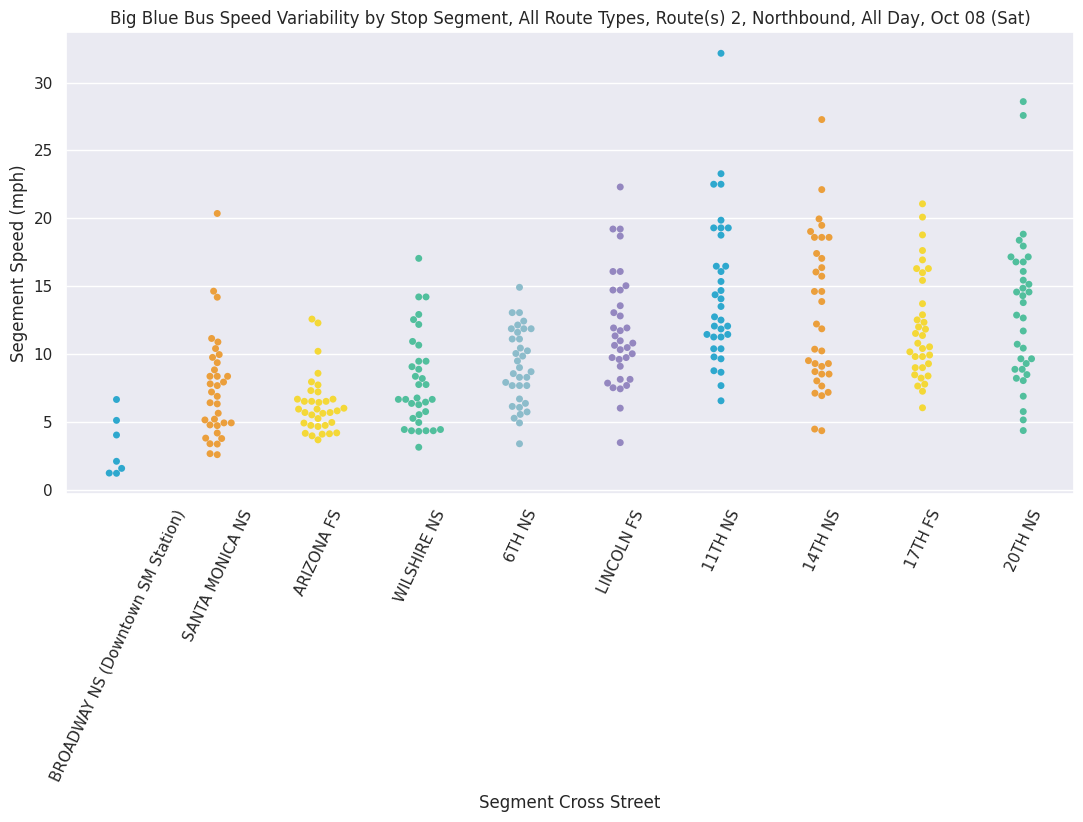

In [29]:
rt_day.chart_variability(num_segments=10)

## Corridor Metrics (for SCCP, LPP, 100 Buses, etc) 

Showing speeds on a map is great, but often it would be nice to have a reasonable estimate of how much time is lost to low speeds in a certain area -- for any combination of routes and times of day. RtFilterMapper includes corridor analysis methods designed to facilitate these estimates.

First, it's necessary to define the corridor. Generally, draw the corridor with a small buffer (~10 meters) around the segment you wish to measure. Note that RtFilterMapper currently only handles one contiguous corridor at a time. To draw the corridor, use any platform that outputs a supported GIS file format. [geojson.io](https://geojson.io) is an easy one, but you could also use ESRI or QGIS.

If using geojson.io:
* Navigate the map to your area of interest
* Click the pentagon-shaped "polygon" tool in the top center right of the map
* Construct your polygon as a series of points
* When back at the start, double-click on the starting point to finish drawing (a complete polygon will look like the screenshot below)
* Save file as geojson

![finished polygon on geojson.io](img/geojson_io.png)

### Attaching Corridor to an RtFilterMapper instance

* first, construct an `RtFilterMapper` on the date of interest as above
* use geopandas to load your corridor file as a geodataframe
* pass that geodataframe to `RtFilterMapper.add_corridor()`

In [30]:
corridor = gpd.read_file('./corridors_100buses/example_santamonica.geojson')

In [31]:
corridor

,geometry
0,"POLYGON ((-118.46334 34.04009, -118.45238 34.0..."


In [32]:
rt_day.add_corridor(corridor)

`add_corridor` finds all shapes with at least one stop within the designated corridor, and tracks all stops for those shapes starting with the stop just before entering the corridor and ending with the stop just after leaving the corridor. You can use `RtFilterMapper.quick_map_corridor()` to confirm corridor and stop locations.

In [33]:
rt_day.quick_map_corridor()

### Using Corridor for Maps and Metrics

In [34]:
# reset to remove filter from earlier
rt_day.reset_filter()

With a corridor attached, you can use the `RtFilterMapper.segment_speed_map()` `corridor` arguement to generate a speed map filtered to just the corridor.

In [35]:
rt_day.segment_speed_map(corridor=True)

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



#### About the Metrics

The schedule-based metric is a daily average of the sum of median trip stop delays along the corridor. To further explain, we take each corridor trip that we have data for and look at the delay in comparison to the schedule at each stop, after subtracting off any delay present as the trip entered the corridor. For each trip we then take the median delay of all stops along the corridor, and sum these medians to create the metric.

The speed-based metric is a daily average of the sum of delays for each trip traversing the corridor as compared to a reference speed of 16 miles per hour. To further explain, we take each corridor trip that we have data for and calculate the hypothetical time it would take for that trip to traverse the corridor at a speed of 16 mph. The difference between the actual time it took for the trip to traverse the corridor and that hypothetical time is the speed-based delay for that trip, and we sum those delays to create the metric. This metric is intended to provide a more consistent basis for comparison independent of scheduling practices.



In [36]:
rt_day.corridor_metrics()

{'schedule_metric_minutes': 80.175, 'speed_metric_minutes': 584.1935799795249}

In [37]:
from rt_analysis import sccp_tools
import numpy as np

In [39]:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

The next cell generates an `OperatorDayAnalysis` for each date in the range that hasn't been ran already, and saves intermediate data to gcs.

In [40]:
for date in date_range:
    analysis_date = date.astype(dt.date)
    check_ran = shared_utils.rt_utils.get_operators(analysis_date, [300])
    if check_ran[300] == 'already_ran':
        continue
    rt_day = rt_parser.OperatorDayAnalysis(300, analysis_date, pbar)
    # don't worry about the CRS not set UserWarning
    rt_day.export_views_gcs()

already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300


In [38]:
sccp_tools.sccp_average_metrics?

Signature:
sccp_tools.sccp_average_metrics(
    itp_id: int,
    date_range: <built-in function arange>,
    corridor: geopandas.geodataframe.GeoDataFrame,
    filter_dict: dict = None,
)
Docstring:
Generate averaged corridor delay metrics for SCCP, LPP programs. For 2022-2023 cycle,
default range is Apr 30 2022 to May 8 2022:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

Optional filter_dict should _not_ be used to generate SCCP/LPP metrics, but is available
for exploratory analysis and other analyses. Supply RtFilterMapper.set_filter params
as dict keys with each param's value as dict values:
filter_dict = {'start_time': '06:00', 'end_time': '10:00', 'route_names': ['2', 'R12']}
File:      ~/data-analyses/rt_delay/rt_analysis/sccp_tools.py
Type:      function


In [44]:
bbb_corridor_metrics = sccp_tools.sccp_average_metrics(itp_id=300, date_range=date_range, corridor=corridor)

found parquet
complete for date: 2022-04-30
found parquet
complete for date: 2022-05-01
found parquet
complete for date: 2022-05-02
found parquet
complete for date: 2022-05-03
found parquet
complete for date: 2022-05-04
found parquet
complete for date: 2022-05-05
found parquet
complete for date: 2022-05-06
found parquet
complete for date: 2022-05-07
found parquet
complete for date: 2022-05-08


In [45]:
bbb_corridor_metrics

{'avg_schedule_metric_minutes': 28.0,
 'avg_speed_metric_minutes': 628.0,
 'all_schedule': [31.908333333333335,
  9.841666666666667,
  0.30833333333333335,
  35.25,
  25.816666666666666,
  59.55,
  42.725,
  52.61666666666667,
  -3.566666666666667],
 'all_speed': [484.1486595413707,
  383.88234806134756,
  726.3330598415508,
  833.6681699201343,
  781.9080956422948,
  841.8386177141758,
  776.2531649614954,
  481.57557779053826,
  340.3238126351311]}